### Student Information
Julian Boaz

Kaggle username: julianboaz

Due: 10/10/2021

UCFID: 4128169


# Introduction

The purpose of this assignment is to use linear models to predict the amount of COVID-19 deaths in the United States


## Creating the dataframe with training data and testing data

Total deaths consists of Pneumonia, Flu, and COVID.

#### A couple of things to note right off the bat
There's lots of overlapping data here, for instance in Group, the week, month and year overlap with each other, so I will likely limit to the *By Week* group which will give me the largest amount of observations.
It also seems that a bunch of the time categories are identical. So it will not be beneficial to analyze a few of the time-related columns.




---

### Loading Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trainData = pd.read_csv('../input/assignment1/train.csv')
testData = pd.read_csv('../input/assignment1/test.csv')



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---

### Looking for missing data



In [2]:
trainData.isnull().sum()

id                                    0
Data As Of                            0
Start Date                            0
End Date                              0
Group                                 0
Year                                  0
Month                             59400
MMWR Week                         14256
Week-Ending Date                  14256
HHS Region                            0
Race and Hispanic Origin Group        0
Age Group                             0
COVID-19 Deaths                   14926
Total Deaths                      24158
Footnote                          38371
dtype: int64

#### So why are there so many null values in the deaths columns? 

The footnote columns describes that if the deaths are between 1-9, that observation was suppressed. In other words, the null value isn't missing data, it means that 1-9 people died in that observation, so now I must
impute data for null values in the death columns, however what is interesting is that there are some death observations that were not suppressed that are between 1-9, so lets find the median of that for imputation

In [3]:
totalDeathDF = trainData.loc[(trainData['Total Deaths'] < 10) & (trainData['Total Deaths'] > 0)]
print(totalDeathDF['Total Deaths'].median())

4.0


In [4]:
covidDeathDF = trainData.loc[(trainData['COVID-19 Deaths'] < 10) & (trainData['COVID-19 Deaths'] > 0)]
print(covidDeathDF['COVID-19 Deaths'].median())

2.0


So I will use the value of 4 to impute the values over Total Deaths and 2 to impute the values over Covid Deaths that are null

In [5]:
trainData['Total Deaths'].fillna(totalDeathDF['Total Deaths'].median(), inplace=True)
trainData['COVID-19 Deaths'].fillna(covidDeathDF['COVID-19 Deaths'].median(), inplace=True)

trainData.isnull().sum()

id                                    0
Data As Of                            0
Start Date                            0
End Date                              0
Group                                 0
Year                                  0
Month                             59400
MMWR Week                         14256
Week-Ending Date                  14256
HHS Region                            0
Race and Hispanic Origin Group        0
Age Group                             0
COVID-19 Deaths                       0
Total Deaths                          0
Footnote                          38371
dtype: int64

So it looks like I've successfully imputed the null values within COVID-19 Deaths and Total Deaths to something that will more realistically give our model something to work on.

---

#### Dealing with outliers

It seems that getting rid of By Year and By Month data is beneficial because they are not independant of the By Week data, and with By Week data I will get more observations to work with.

With that being said, I will **cap** the data for deaths to deal with outliers, as I don't want to simply get rid of outliers, however outliers will negatively affect linear models.

I will also be limiting the HHS Region to only *United States* as the testing data seems to only be in the United States region as well, I wouldn't want to train my model on specific regions if what I'm testing it on is not specific.

In [6]:
testData = testData[testData['Group'] == 'By Week']

testData['Group'].unique()

array(['By Week'], dtype=object)

In [7]:
# limit the dataframe to By Week group and under united states
weeklyDeaths = trainData[trainData['HHS Region'] == 'United States']

In [8]:
weeklyDeaths = weeklyDeaths[weeklyDeaths['Group'] == 'By Week']

<AxesSubplot:>

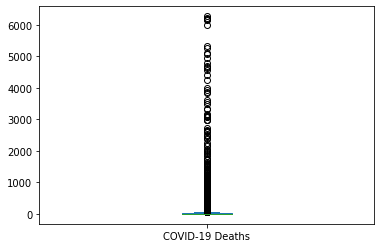

In [9]:
# showing outliers
plt.figure()
weeklyDeaths['COVID-19 Deaths'].plot(kind='box')


In [10]:
# looking at standard deviation and mean of covid deaths
covidSTD = weeklyDeaths['COVID-19 Deaths'].std()
covidMean = weeklyDeaths['COVID-19 Deaths'].mean()


# std and mean of total deaths
totalSTD = weeklyDeaths['Total Deaths'].std()
totalMean = weeklyDeaths['Total Deaths'].mean()

covidCap = ((covidSTD * 3) + covidMean)
totalCap = ((totalSTD * 3) + totalMean)

print("Cap for covid deaths:", ((covidSTD * 3) + covidMean))
print("Cap for total deaths:", ((totalSTD * 3) + totalMean))

Cap for covid deaths: 1416.7198576668188
Cap for total deaths: 8905.317475404516


#### Explanation for the code above
The way I decided to handle the outliers was the cap them as stated above.

The method I used to capping the outliers was going to three standard deviations and adding the mean. This is because three standard deviations accounts for 99.5% of the data in my dataset, so the .3% on the high side I could likely safely assume are outliers. Adding the mean to the top 99.7% of the data gives me a good number to cap all the data at.

So I'll set all values for covid deaths over 1416.72 to 1416.72, and all the values in total deaths over 8905.3 to 8905.3

In [11]:
weeklyDeaths.loc[weeklyDeaths['COVID-19 Deaths'] > covidCap, 'COVID-19 Deaths'] = covidCap


print("The new max for covid-19 deaths in the data set is:", weeklyDeaths['COVID-19 Deaths'].max())


The new max for covid-19 deaths in the data set is: 1416.7198576668188


In [12]:
weeklyDeaths.loc[weeklyDeaths['Total Deaths'] > totalCap, 'Total Deaths'] = totalCap

print("The new max for total deaths in the data set is:", weeklyDeaths['Total Deaths'].max())

The new max for total deaths in the data set is: 8905.317475404516


Now I've successfully capped the deaths, so hopefully the linear model can be more successful.

---
#### Showing correlation between deaths other than COVID, and COVID from the dataset

In [13]:
otherDeaths = weeklyDeaths
for x in otherDeaths.index:
    weeklyDeaths.loc[x, 'Total Deaths'] = weeklyDeaths.loc[x, 'Total Deaths'] - weeklyDeaths.loc[x, 'COVID-19 Deaths']



In [14]:
# calculating correlation between other deaths and covid deaths.

print("The correlation is:", otherDeaths['Total Deaths'].corr(otherDeaths['COVID-19 Deaths']))


The correlation is: 0.7287287305377069


So obviously I wouldn't want to compare Total Deaths to COVID-19 Deaths without subtracting COVID-19 Deaths because obviously the correlation would be high, as the numbers overlap, but after subtracting the covid deaths from the total deaths and still having a high correlation, I will definitely be using total deaths as a feature in my model. Now whether or not I want Total Deaths to include the covid deaths is another story.



---

#### Testing models

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
ols = LinearRegression()
rr = Ridge()
las = Lasso()
en = ElasticNet()

# going to use age,covid deaths and total deaths and race and see how it works
features = ['Race and Hispanic Origin Group', 'Age Group', 'COVID-19 Deaths', 'Total Deaths']
testFeatures = ['Race and Hispanic Origin Group', 'Age Group', 'Total Deaths']
#X = pd.get_dummies(weeklyDeaths[testFeatures])
X = pd.get_dummies(otherDeaths[testFeatures])
X_test = pd.get_dummies(testData[testFeatures])
y = weeklyDeaths['COVID-19 Deaths']

# Ordinary Least Squares

ols.fit(X,y)
performanceOLS = ols.predict(X)
valOLS = cross_val_score(ols, X, y)


rmseOLS = mean_squared_error(y, performanceOLS, squared=False) 

print("The rmse of Ordinary Least Squares model is:", rmseOLS)

# Ridge Regression
rr.fit(X,y)
performanceRR = rr.predict(X)
valRR = cross_val_score(rr, X, y)

rmseRR = mean_squared_error(y, performanceRR, squared=False)

print("The rmse of Ridge Regression model is:", rmseRR)

# Lasso Regression
las.fit(X,y)
performanceLAS = las.predict(X)
valLAS = cross_val_score(las, X, y)

rmseLAS = mean_squared_error(y, performanceLAS, squared=False)

print("The rmse of Lasso Regression model is:", rmseLAS)

# Elastic Net Regression
en.fit(X,y)
performanceEN = en.predict(X)
valEN = cross_val_score(en, X, y)

rmseEN = mean_squared_error(y, performanceEN, squared=False)

print("The rmse of Elastic Net Regression is:", rmseEN)

# description of rmse?
rsmeDF = pd.DataFrame()
rsmeDF['OLS'] = valOLS
rsmeDF['RR'] = valRR
rsmeDF['LAS'] = valLAS
rsmeDF['EN'] = valEN
rsmeDF.describe()



The rmse of Ordinary Least Squares model is: 159.54496434172447
The rmse of Ridge Regression model is: 159.54498494768148
The rmse of Lasso Regression model is: 159.90708008176725
The rmse of Elastic Net Regression is: 164.85731067785795


,OLS,RR,LAS,EN
count,5.000000,5.000000,5.000000,5.000000
mean,-0.189808,-0.189625,-0.183596,-0.175620
std,1.950195,1.949921,1.939219,1.889916
min,-3.672912,-3.672229,-3.646138,-3.548281
25%,0.502766,0.502691,0.492224,0.464719
50%,0.683548,0.683503,0.676236,0.639626
75%,0.748246,0.748486,0.762820,0.778369
max,0.789314,0.789423,0.796879,0.787468


I have absolutely no idea why my ```.describe()``` function isn't working correctly


**So far my best performing model after submitting was with Elastic Net regression**

---

#### Creating evaluation on EN

In [16]:
evaluationOLS = ols.predict(X_test)
evaluationRR = rr.predict(X_test)
evaluationLAS = las.predict(X_test)
evaluationEN = en.predict(X_test)

output = pd.DataFrame({
    'id': testData['id'],
    'COVID-19 Deaths': evaluationEN
})
print(output.to_string())
output.to_csv('submission.csv', index=False)

        id  COVID-19 Deaths
0     5328        42.156106
1     5329        39.973621
2     5330        57.399379
3     5331        62.805310
4     5332        73.319972
5     5333       142.907408
6     5334       130.101645
7     5335       135.682205
8     5336       138.881289
9     5337        14.891666
10    5338        14.539500
11    5339        15.797441
12    5340        18.254525
13    5341        19.210854
14    5342        30.939873
15    5343        32.471608
16    5344        30.934262
17    5345        26.913754
18    5346        17.415916
19    5347        17.368804
20    5348        17.813269
21    5349        19.253509
22    5350        23.362055
23    5351        42.107296
24    5352        52.282205
25    5353        64.878988
26    5354        68.179756
27    5355        35.923461
28    5356        29.876970
29    5357        56.454323
30    5358        58.504669
31    5359        73.391760
32    5360       204.294881
33    5361       203.386192
34    5362       163